In [109]:
import pandas as pd
import numpy as np
from pyproj import Proj, Transformer
from concurrent import futures
import os
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
import rioxarray as rxr

### ラスター画像の読み込み

In [110]:
path_to_image = "../satelliteImage/Sentinel2_L2A_MississippiS501.tif"
image = rxr.open_rasterio(path_to_image)

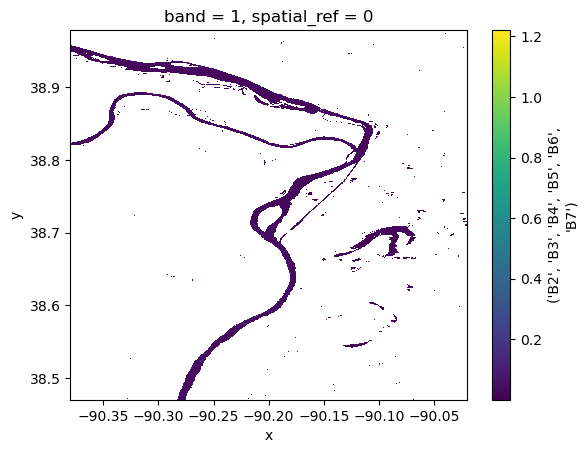

In [111]:
image = image.where(image>0, drop=True)
image.isel(band=0).plot() #6.0s

### RivCenterLineの読み込み

In [113]:
filePath = "../dat_satellite/RivCenterLine_MS_sparse.csv"
df = pd.read_csv(filePath)
#38.60284134429668, -90.45334533854292 38.99242639934311, -90.04685118281743
df = df.query('38.60284134429668<latitude < 38.99242639934311 & -90.45334533854292<longitude<-90.04685118281743')
df = df.reset_index(drop=True)
df.head()

,note,flag_eleva,flag_hills,crs,latitude,flag_water,flag_snowI,flag_cldSh,endsOverEd,orthogonal,endsInWate,flag_cloud,width,image_id,longitude
0,NaN,128.448618,0.0,EPSG:32616,38.934342,0.452316,0.0,0.0,0,1.692969,1,0.0,247.619815,LC08_L1TP_023033_20170915_20170928_01_T1,-90.287079
1,NaN,128.461406,0.0,EPSG:32616,38.934352,0.495257,0.0,0.0,0,1.692969,1,0.0,277.335058,LC08_L1TP_023033_20170915_20170928_01_T1,-90.286734
2,NaN,128.881630,0.0,EPSG:32616,38.934362,0.495688,0.0,0.0,0,1.692969,1,0.0,350.685640,LC08_L1TP_023033_20170915_20170928_01_T1,-90.286388
3,NaN,128.893489,0.0,EPSG:32616,38.934372,0.538163,0.0,0.0,0,1.692969,0,0.0,308.105084,LC08_L1TP_023033_20170915_20170928_01_T1,-90.286043
4,NaN,129.611111,0.0,EPSG:32616,38.934381,0.444444,0.0,0.0,0,1.570796,0,0.0,215.406592,LC08_L1TP_023033_20170915_20170928_01_T1,-90.285697


In [114]:
projection_to_epsg3857 = Transformer.from_crs('epsg:4326', "epsg:3857")
def latlon_to_xy(lat, lon):

    x,y = projection_to_epsg3857.transform(lat,lon)
    return x, y

In [115]:
future_list = []
with futures.ProcessPoolExecutor(os.cpu_count()) as executor:
    for lat,lon in zip(df["latitude"],df["longitude"]):
        future = executor.submit(latlon_to_xy,lat,lon)
        future_list.append(future)

x = [f.result()[0] for f in future_list]
y = [f.result()[1] for f in future_list]
points = np.array([[x0,y0] for x0,y0 in zip(x,y)])

In [116]:
df["x"] = x
df["y"] = y
df.head()

,note,flag_eleva,flag_hills,crs,latitude,flag_water,flag_snowI,flag_cldSh,endsOverEd,orthogonal,endsInWate,flag_cloud,width,image_id,longitude,x,y
0,NaN,128.448618,0.0,EPSG:32616,38.934342,0.452316,0.0,0.0,0,1.692969,1,0.0,247.619815,LC08_L1TP_023033_20170915_20170928_01_T1,-90.287079,-1.005071e+07,4.712271e+06
1,NaN,128.461406,0.0,EPSG:32616,38.934352,0.495257,0.0,0.0,0,1.692969,1,0.0,277.335058,LC08_L1TP_023033_20170915_20170928_01_T1,-90.286734,-1.005067e+07,4.712272e+06
2,NaN,128.881630,0.0,EPSG:32616,38.934362,0.495688,0.0,0.0,0,1.692969,1,0.0,350.685640,LC08_L1TP_023033_20170915_20170928_01_T1,-90.286388,-1.005063e+07,4.712274e+06
3,NaN,128.893489,0.0,EPSG:32616,38.934372,0.538163,0.0,0.0,0,1.692969,0,0.0,308.105084,LC08_L1TP_023033_20170915_20170928_01_T1,-90.286043,-1.005060e+07,4.712275e+06
4,NaN,129.611111,0.0,EPSG:32616,38.934381,0.444444,0.0,0.0,0,1.570796,0,0.0,215.406592,LC08_L1TP_023033_20170915_20170928_01_T1,-90.285697,-1.005056e+07,4.712277e+06


### 観測地点の座標の設定（合流前）

In [208]:
def degToLatLon(hour,min,sec):
    return hour+min/60+sec/3600

In [209]:
confluence =  [-90.11845811930084,38.810546798605905] #from google map
MO = [degToLatLon(38.,47.,13.9), degToLatLon(-90.,-28.,-18.5)]
MS_upper = [degToLatLon(38.,57.,4.), degToLatLon(-90.,-22.,-16.)]

In [119]:
MO = latlon_to_xy(MO[0], MO[1])
MS_upper = latlon_to_xy(MS_upper[0], MS_upper[1])

### 観測地点付近のCenterlineの点群を抽出

In [120]:
# 最近傍点を見つけるためのNearestNeighborsモデルを構築
k_neighbors = 6  # 1つの最近傍点を見つける例
nbrs = NearestNeighbors(n_neighbors=k_neighbors, algorithm='auto').fit(points)
distances_MO, indices_MO = nbrs.kneighbors([MO])
distances_MS_upper, indices_MS_upper = nbrs.kneighbors([MS_upper])
indices_MO = indices_MO[0]
indices_MS_upper = indices_MS_upper[0]

In [207]:
print(indices_MS_upper)

[92 94 95 96 97 98]


In [121]:
df_MO = df[df.index.isin(indices_MO)]
df_MS_upper = df[df.index.isin(indices_MS_upper)]


### 点群を中心とし、cross-sectionと流下方向+-100mを辺とする長方形バッファ領域を抽出し、バッファ領域に含まれる点のスペクトルを抽出

In [126]:

def point_in_quadrilateral_vectorized(x_points, y_points, quadrilateral_points):
    """
    ベクトル演算を使用して、四角形領域の内部に複数の点が存在するかどうかを判定する関数

    Parameters:
        x_points, y_points: テストする点の座標 (配列)
        quadrilateral_points: 四角形の頂点の座標 [(x1, y1), (x2, y2), (x3, y3), (x4, y4)]

    Returns:
        np.array: 各点が四角形の内部にあるかどうかを示すブール値の配列
    """
    # 四角形の各辺に対して、点が左側（外側）か右側（内側）にあるかを判定
    sides = np.array([
        (quadrilateral_points[i][0] - quadrilateral_points[i - 1][0]) * (y_points - quadrilateral_points[i - 1][1]) -
        (x_points - quadrilateral_points[i - 1][0]) * (quadrilateral_points[i][1] - quadrilateral_points[i - 1][1])
        for i in range(len(quadrilateral_points))
    ])

    # 各点が四角形の内部にあるかどうかを判定
    result = np.logical_or(np.all(sides >= 0, axis=0), np.all(sides <= 0, axis=0))

    return result

In [145]:
#xy座標への変換
future_list = []
with futures.ProcessPoolExecutor(os.cpu_count()) as executor:
    for lat,lon in zip(image.y.values,image.x.values):
        future = executor.submit(latlon_to_xy,lat,lon)
        future_list.append(future)

x_points = [f.result()[0] for f in future_list]
y_points = [f.result()[1] for f in future_list]
#points = np.array([[x0,y0] for x0,y0 in zip(x,y)])

In [183]:
def spectrum_extract(image,boolMatrix):
    """
    boolMatrix=Trueの点のspectrumをListにして渡す
    """
    spectrum = []
    #fig,ax = plt.subplots()
    for y in range(len(image.x.values)):
        
        for x in range(len(image.x.values)):

            if boolMatrix[x,y]:
                spectrum.append(image[:,x,y].values)
                #ax.plot(image[:,x,y])
    #plt.show()
    return spectrum

In [184]:
def findBuffer(df,indices,x_points,y_points,buffer=100):

    ## read raster
    x_points,y_points = np.meshgrid(x_points,y_points)

    # empty result list
    spectrum = []

    #start iteration for each index
    for i,index in enumerate(indices):

        ##set parameters
        theta = df["orthogonal"][index] #in radians
        w = df["width"][index]
        cos = np.cos(theta)
        sin = np.sin(theta)
        center = np.array([df["x"][index],df["y"][index]])

        ## determine the apex of the rectangular
        p1 = center + np.array([w*cos + buffer*sin, w*sin - buffer*cos])
        p2 = center + np.array([w*cos - buffer*sin, w*sin + buffer*cos])
        p3 = 2 * center - p1
        p4 = 2 * center - p2
        quadrilateral_points = [p1,p2,p3,p4]

        ## make bool matrix
        result = point_in_quadrilateral_vectorized(x_points, y_points, quadrilateral_points)

        ## add
        res = spectrum_extract(image,result)
        spectrum += res
    return spectrum

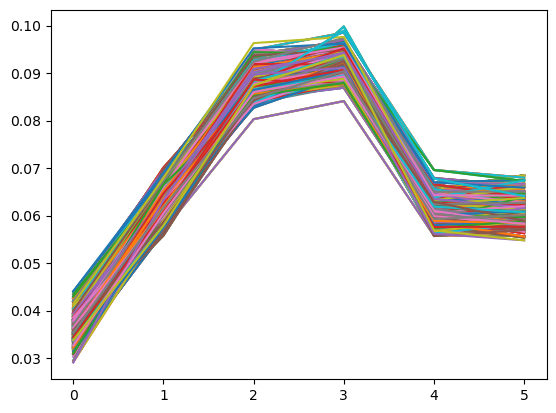

In [189]:
result = findBuffer(df_MO,indices_MO,x_points,y_points,buffer=100)
#plot
fig,ax  = plt.subplots()
spectrum = []
for res in result:
    if res[3] < 0.10:
        ax.plot(res)
        spectrum.append(res)
plt.show()

In [202]:
ave = []
for i in range(len(spectrum[0])):
    sum = 0
    for j in range(len(spectrum)):
        sum += spectrum[j][i]
    ave.append(sum/len(spectrum))
print(ave)

[0.03614158926728592, 0.06203364293085663, 0.08725366357069149, 0.09127358101135215, 0.06068916408668747, 0.0603813209494325]


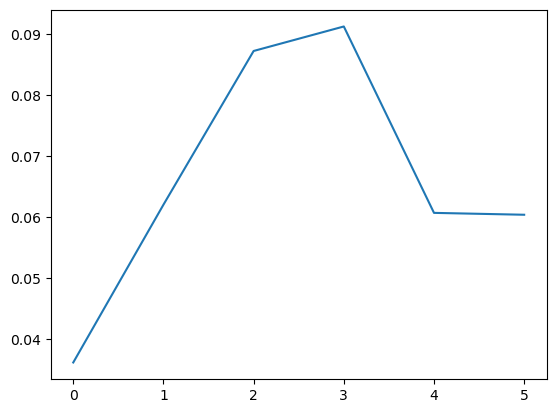

In [203]:
fig,ax  = plt.subplots()
ax.plot(ave)

In [204]:
def plot_spectrum(spectrum):
    fig,ax  = plt.subplots()
    spectrum = []
    for res in result:
        ax.plot(res)
        spectrum.append(res)
    plt.show()
    return spectrum

In [205]:
def ave_spectrum(spectrum):
    ave = []
    for i in range(len(spectrum[0])):
        sum = 0
        for j in range(len(spectrum)):
            sum += spectrum[j][i]
        ave.append(sum/len(spectrum))
    return ave